In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import dynamiqs as dq
import jax.numpy as jnp
from scipy.interpolate import RegularGridInterpolator
import cvxpy as cp
from scipy.linalg import sqrtm


In [4]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))


def add_2d_positional_encoding(x):
    B, C, H, W = x.shape
    device = x.device

    y_pos = torch.linspace(-1, 1, H, device=device).view(1, 1, H, 1).expand(B, 1, H, W)
    x_pos = torch.linspace(-1, 1, W, device=device).view(1, 1, 1, W).expand(B, 1, H, W)
    
    return torch.cat([x, x_pos, y_pos], dim=1)  # Add 2 channels


class ConvResMLPDAE_32x32(nn.Module):
    def __init__(self):
        super().__init__()

        # Positional encoding → add 2 channels
        self.input_proj = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)  # (B, 3, 32, 32) → (B, 16, 16, 16)

        self.encoder = nn.Sequential(
            ResBlock(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # → (B, 32, 8, 8)
            nn.ReLU(),
            ResBlock(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # → (B, 64, 4, 4)
            nn.ReLU(),
            ResBlock(64)
        )

        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 64 * 4 * 4),
            nn.ReLU()
        )
        self.unflatten = nn.Unflatten(1, (64, 4, 4))

        self.decoder = nn.Sequential(
            ResBlock(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 8, 8)
            nn.ReLU(),
            ResBlock(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 16, 16)
            nn.ReLU(),
            ResBlock(16),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # (B, 1, 32, 32)
            nn.Tanh()
        )

    def forward(self, x):
        x = add_2d_positional_encoding(x)  # (B, 1, 32, 32) → (B, 3, 32, 32)
        x = self.input_proj(x)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.mlp(x)
        x = self.unflatten(x)
        return self.decoder(x)


In [35]:
class WignerNPZDataset(Dataset):
    def __init__(self, folder_path, normalize=True):
        self.folder_path = folder_path
        self.files = sorted([f for f in os.listdir(folder_path) if f.endswith(".npz")])
        self.normalize = normalize

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.folder_path, self.files[idx])
        data = np.load(path, allow_pickle=True)
        noisy = data["noisy"].astype(np.float32)
        clean = data["clean"].astype(np.float32)
        dm = data["dm"].astype(np.complex64) 
        print(dm)

        # Resize or crop here if needed
        if self.normalize:
            noisy = np.clip(noisy, -1.0, 1.0)
            clean = np.clip(clean, -1.0, 1.0)

        # Add channel dimension for CNNs
        noisy = torch.tensor(noisy).unsqueeze(0)  # shape (1, H, W)
        clean = torch.tensor(clean).unsqueeze(0)
    
        return noisy, clean, dm


In [6]:
def wigner_fct(x, y, data):
    xvec, yvec, W = data

    # Ensure inputs are NumPy arrays
    xvec = np.asarray(xvec)
    yvec = np.asarray(yvec)
    W = np.asarray(W)

    # Create interpolator (lazy init is better in practice but kept inline here)
    interp = RegularGridInterpolator((xvec, yvec), W.T)

    # Interpolation expects array of shape (N, 2)
    point = np.array([[x, y]])

    return float(interp(point))  # Return scalar
    # i = np.where(np.isclose(xvec, x))[0]
    # j = np.where(np.isclose(yvec, y))[0]

    # if len(i) == 0 or len(j) == 0:
    #     raise ValueError(f"Point (x={x}, y={y}) not found in grid.")

    # return W[i[0], j[0]]

def pk(x, y, data):
    return 1/2 * (1 + np.pi/2 * wigner_fct(x, y, data))  # Return scalar

def measurement_operator(alpha, dim, original_dim=None):
    """
    Construct E_alpha for a given displacement alpha.

    If original_dim is provided, returns truncated operator of shape (original_dim, original_dim).
    """
    D = dq.displace(dim, alpha)
    P = dq.parity(dim)
    E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))

    if original_dim is not None and original_dim < dim:
        E = E.data  # unwrap before slicing
        E = E[:original_dim, :original_dim]
    else:
        E = E.data  # always unwrap for CVXPY use
    return E


In [7]:
def loss_cvxpy(rho_tilde, X, Y, data, dim, original_dim=None):
    alpha_k = (X + 1j * Y).ravel()
    points = np.stack([X.ravel(), Y.ravel()], axis=-1)
    target_p_k = np.array([pk(x, y, data) for x, y in points])

    pred_p_k = []
    for alpha in alpha_k:
        E = measurement_operator(alpha, dim, original_dim=original_dim)
        p = cp.real(cp.trace(E @ rho_tilde))
        pred_p_k.append(p)

    pred_p_k = cp.vstack(pred_p_k)
    target_p_k = target_p_k.reshape(-1, 1)

    return cp.sum_squares(pred_p_k - target_p_k) 

def fidelity(rho, rho_tilde):
    sqrt_rho = sqrtm(rho)
    inner = sqrt_rho @ rho_tilde @ sqrt_rho
    sqrt_inner = sqrtm(inner)
    return np.real(np.trace(sqrt_inner))**2


In [8]:
def fit_dm(data, rho_true, N, dim_ext, dim=10):
    
    # Choose displacement points
    # xmin, xmax = -3, 3
    # ymin, ymax = -3, 3

    # # Number of points per axis
    # #N = 50

    # # Generate grid of (x, y) values
    # x_vals = np.linspace(xmin, xmax, N)
    # y_vals = np.linspace(ymin, ymax, N)
    
    x_vals, y_vals, _ = data

    # Create 2D grid of x and y values
    X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

    rho = cp.Variable((dim, dim), hermitian=True)
    #rho = 0.5 * (rho + rho.H)

    constraints = [
        rho >> 0,
        cp.trace(rho) == 1,
    ]

    loss_expr = loss_cvxpy(rho, X, Y, data, dim=dim_ext, original_dim=dim)
    problem = cp.Problem(cp.Minimize(loss_expr), constraints)
    problem.solve(solver=cp.SCS)

    print("Optimal value:", problem.value)
    
    if rho_true is not None:
        print("Fidelity:", fidelity(rho_true, rho.value))

        diag_true = np.real(np.diag(rho_true))
        diag_reco = np.real(np.diag(rho.value))

        # Print
        print("True diag:        ", np.round(diag_true, 5))
        print("Reconstructed diag:", np.round(diag_reco, 5))
        
        return fidelity(rho_true, rho.value)
    
    else:
        diag_reco = np.real(np.diag(rho.value))
        print("True diag:        ", np.round(diag_reco, 5))
        

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_20420\580499977.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('conv_res_mlp_dae_32x32.pt

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
<class 'numpy.ndarray'>


C:\Users\ZenBook\AppData\Local\Temp\ipykernel_20420\632412795.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 0.08539708364981716
Fidelity: 0.2895602932072406
True diag:         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [0.20411 0.28956 0.21742 0.09713 0.03372 0.00782 0.00532 0.00597 0.00481
 0.00463 0.00471 0.00275 0.00864 0.00387 0.00467 0.00353 0.0063  0.00296
 0.00422 0.00638 0.00576 0.00434 0.0049  0.00383 0.00327 0.00618 0.00535
 0.00487 0.00285 0.00391 0.00469 0.00655 0.00305 0.00334 0.00261 0.00359
 0.00167 0.00351 0.00271 0.00451]
Optimal value: 0.0026200062883377246
Fidelity: 0.9415893057523705
True diag:         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [8.0000e-04 9.4159e-01 5.9000e-03 1.1900e-03 9.2000e-04 3.2300e-03
 6.5000e-04 1.4400e-03 8.9000e-04 1.1500e-03 9.7000e-04 6.0000e-04
 7.9000e-04 9.7000e-04 1.3500e-03 5.6000e-04 9.6000e-04 9.6000e-04
 8.1000e-04 1.1400e

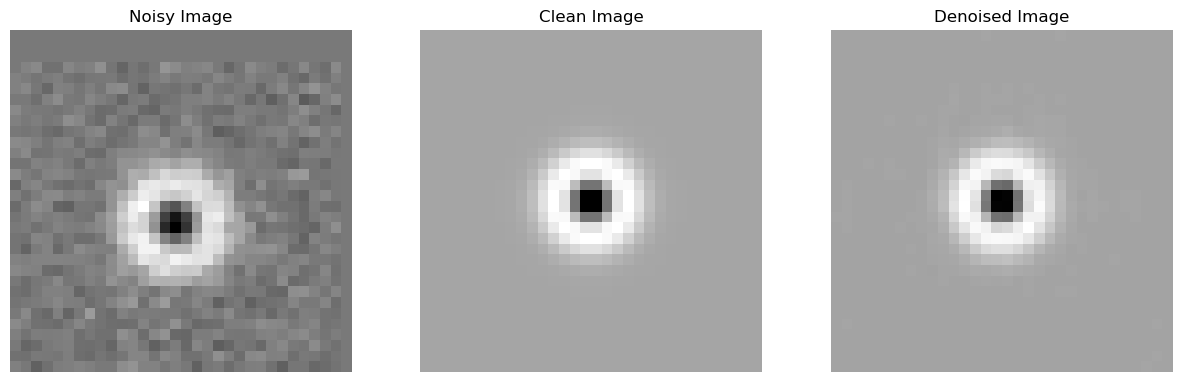

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
<class 'numpy.ndarray'>
Optimal value: 0.11042186953340005
Fidelity: 0.46225527258590676
True diag:         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [0.1316  0.46226 0.17814 0.05589 0.01678 0.01239 0.00453 0.00703 0.00444
 0.00288 0.003   0.00572 0.00656 0.00793 0.00405 0.00248 0.00552 0.00419
 0.0022  0.00354 0.00351 0.00502 0.005   0.00535 0.00614 0.00417 0.00463
 0.00297 0.00353 0.00691 0.0037  0.00405 0.00201 0.00268 0.00167 0.00578
 0.00162 0.00288 0.00118 0.00607]
Optimal value: 0.0033418841999091455
Fidelity: 0.9765767191010822
True diag:         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

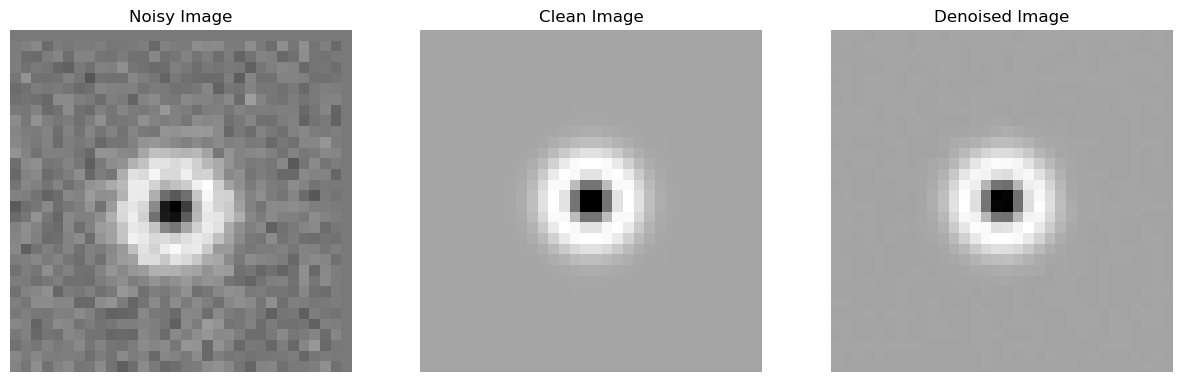

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
<class 'numpy.ndarray'>
Optimal value: 0.08509309038823003
Fidelity: 0.3150850068468613
True diag:         [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [0.03203 0.20489 0.31509 0.18368 0.07213 0.02641 0.00953 0.00708 0.00853
 0.00688 0.00555 0.00731 0.00713 0.00555 0.00418 0.00865 0.00743 0.00308
 0.00522 0.00669 0.00529 0.00647 0.00463 0.00536 0.00598 0.00198 0.00639
 0.00264 0.00527 0.00307 0.00409 0.00185 0.00348 0.00247 0.00236 0.00178
 0.00257 0.00176 0.00329 0.00221]
Optimal value: 0.002175607560906713
Fidelity: 0.9568387524450205
True diag:         [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

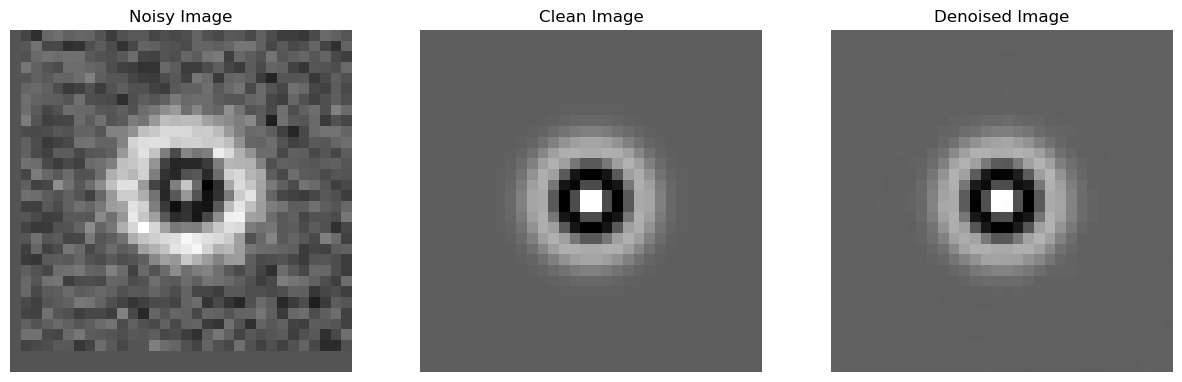

[[ 1.22030787e-01+0.0000000e+00j  1.76362351e-01-1.4844530e-02j
   1.78953186e-01-3.0340154e-02j ... -3.10376364e-17-1.0748418e-18j
  -7.28793352e-18+3.5997093e-19j -1.77665243e-18+2.3827517e-19j]
 [ 1.76362351e-01+1.4844530e-02j  2.56689608e-01+2.4567770e-10j
   2.62318939e-01-2.2079550e-02j ... -4.47257186e-17-5.3289891e-18j
  -1.05765166e-17-3.6630621e-19j -2.59665333e-18+1.2823977e-19j]
 [ 1.78953186e-01+3.0340154e-02j  2.62318939e-01+2.2079550e-02j
   2.69970924e-01+5.7003291e-12j ... -4.52481923e-17-9.2930077e-18j
  -1.07769565e-17-1.2840947e-18j -2.66462999e-18-9.2302997e-20j]
 ...
 [-3.10376364e-17+1.0748418e-18j -4.47257186e-17+5.3289891e-18j
  -4.52481923e-17+9.2930069e-18j ...  7.90366255e-33+0.0000000e+00j
   1.85046192e-33-1.5574777e-34j  4.49779771e-34-7.6252224e-35j]
 [-7.28793352e-18-3.5997093e-19j -1.05765166e-17+3.6630618e-19j
  -1.07769565e-17+1.2840947e-18j ...  1.85046192e-33+1.5574777e-34j
   4.36312509e-34+0.0000000e+00j  1.06808264e-34-8.9894574e-36j]
 [-1.77665

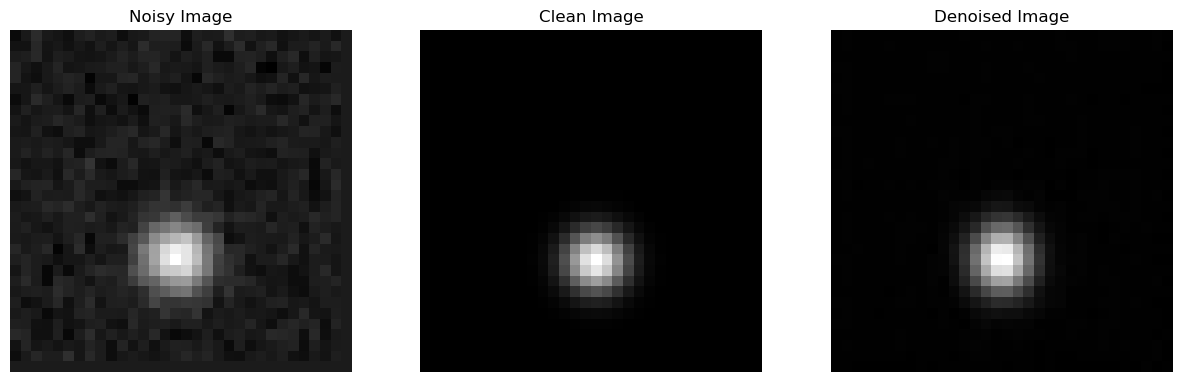

[[ 1.3131753e-03-1.0408341e-17j  3.3756832e-03-2.1684356e-04j
   6.1106198e-03-7.8831048e-04j ... -4.0930220e-10-3.9537087e-10j
  -1.7580266e-10-1.4926399e-10j -9.1160579e-11-6.7843203e-11j]
 [ 3.3756832e-03+2.1684356e-04j  8.7134270e-03+2.0423788e-11j
   1.5838293e-02-1.0174102e-03j ... -9.8687580e-10-1.0839385e-09j
  -4.2727510e-10-4.1273207e-10j -2.2313688e-10-1.8945280e-10j]
 [ 6.1106198e-03+7.8831048e-04j  1.5838293e-02+1.0174102e-03j
   2.8907873e-02+8.4064311e-11j ... -1.6672679e-09-2.0854931e-09j
  -7.2846085e-10-8.0010831e-10j -3.8347209e-10-3.7042033e-10j]
 ...
 [-4.0930220e-10+3.9537087e-10j -9.8687580e-10+1.0839385e-09j
  -1.6672679e-09+2.0854933e-09j ...  2.4661325e-16-6.4040399e-24j
   9.9736144e-17-6.4067393e-18j  4.8839976e-17-6.3006546e-18j]
 [-1.7580266e-10+1.4926399e-10j -4.2727510e-10+4.1273207e-10j
  -7.2846085e-10+8.0010831e-10j ...  9.9736144e-17+6.4067380e-18j
   4.0502062e-17+4.5215436e-25j  1.9915710e-17-1.2793229e-18j]
 [-9.1160579e-11+6.7843203e-11j -2.23136

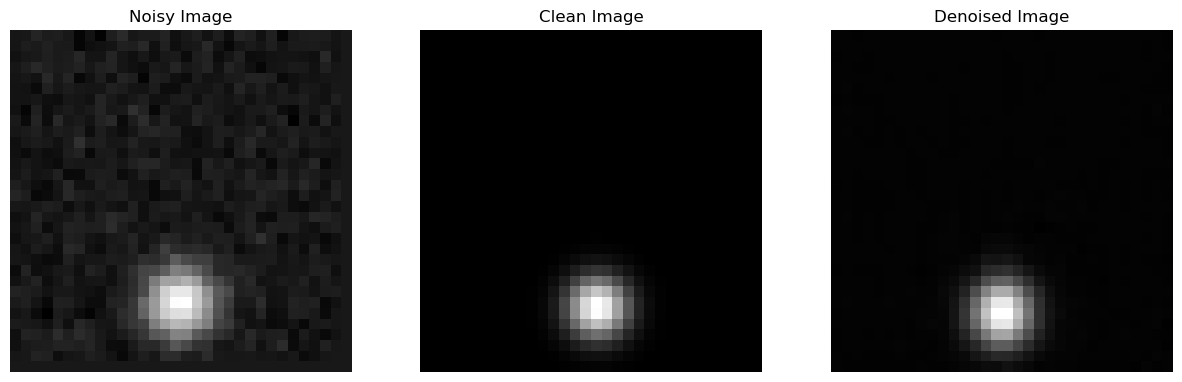

[[ 1.2241665e-02+0.0000000e+00j  2.5584316e-02-2.2919897e-03j
   3.7505422e-02-6.7742555e-03j ... -2.6440369e-12+4.3824338e-13j
  -8.7194547e-13+2.2599086e-13j -3.1953506e-13+1.1409134e-13j]
 [ 2.5584316e-02+2.2919897e-03j  5.3898748e-02-2.3227620e-10j
   7.9652324e-02-7.1356832e-03j ... -5.6079234e-12+4.2086208e-13j
  -1.8646235e-12+3.0905365e-13j -6.8916948e-13+1.7861769e-13j]
 [ 3.7505422e-02+6.7742551e-03j  7.9652324e-02+7.1356837e-03j
   1.1865601e-01-7.6121709e-10j ... -8.3431855e-12-1.2048008e-13j
  -2.7964824e-12+2.0986533e-13j -1.0421115e-12+1.7272419e-13j]
 ...
 [-2.6440369e-12-4.3824341e-13j -5.6079234e-12-4.2086208e-13j
  -8.3431855e-12+1.2048012e-13j ...  5.8676555e-22+1.9575859e-30j
   1.9641893e-22-1.7595956e-23j  7.3099714e-23-1.3203070e-23j]
 [-8.7194547e-13-2.2599086e-13j -1.8646235e-12-3.0905367e-13j
  -2.7964824e-12-2.0986533e-13j ...  1.9641893e-22+1.7595956e-23j
   6.6278623e-23+2.5006357e-31j  2.4865958e-23-2.2275909e-24j]
 [-3.1953506e-13-1.1409134e-13j -6.89169

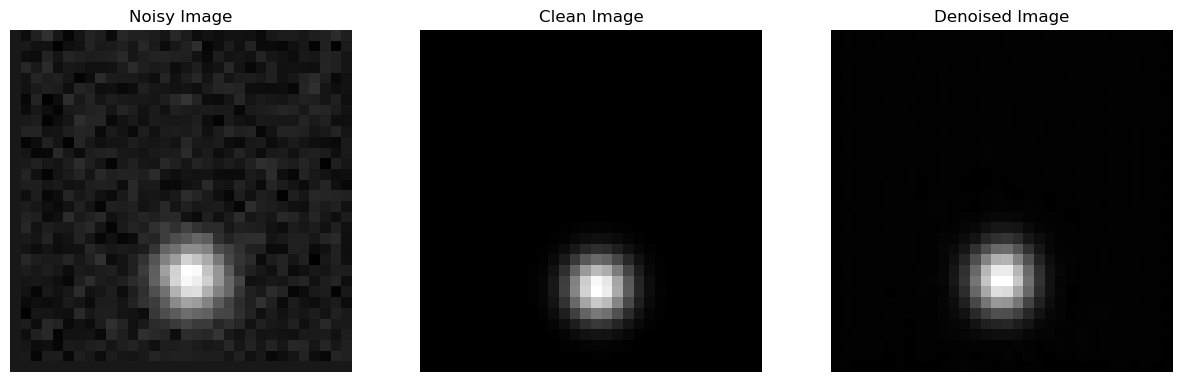

[[ 2.7881764e-04-8.23993651e-18j  7.9636625e-04-4.58683717e-05j
   1.6030312e-03-1.85272365e-04j ... -3.1182072e-09-4.99688113e-09j
  -1.5032490e-09-2.12611928e-09j -9.3079633e-10-1.16773702e-09j]
 [ 7.9636625e-04+4.58683717e-05j  2.2821482e-03+4.48270414e-12j
   4.6090991e-03-2.65464681e-04j ... -8.0842675e-09-1.47852024e-08j
  -3.9438506e-09-6.31997743e-09j -2.4664604e-09-3.48844686e-09j]
 [ 1.6030312e-03+1.85272365e-04j  4.6090991e-03+2.65464681e-04j
   9.3395635e-03+1.40345999e-11j ... -1.4607396e-08-3.08010435e-08j
  -7.2299726e-09-1.32227864e-08j -4.5755577e-09-7.33228278e-09j]
 ...
 [-3.1182072e-09+4.99688158e-09j -8.0842675e-09+1.47852015e-08j
  -1.4607396e-08+3.08010470e-08j ...  1.2442556e-13+3.88234070e-22j
   5.4915494e-14-3.16291399e-15j  3.1337542e-14-3.62184046e-15j]
 [-1.5032490e-09+2.12611928e-09j -3.9438506e-09+6.31997787e-09j
  -7.2299726e-09+1.32227864e-08j ...  5.4915494e-14+3.16291441e-15j
   2.4317474e-14+1.27382785e-22j  1.3922960e-14-8.01902767e-16j]
 [-9.30796

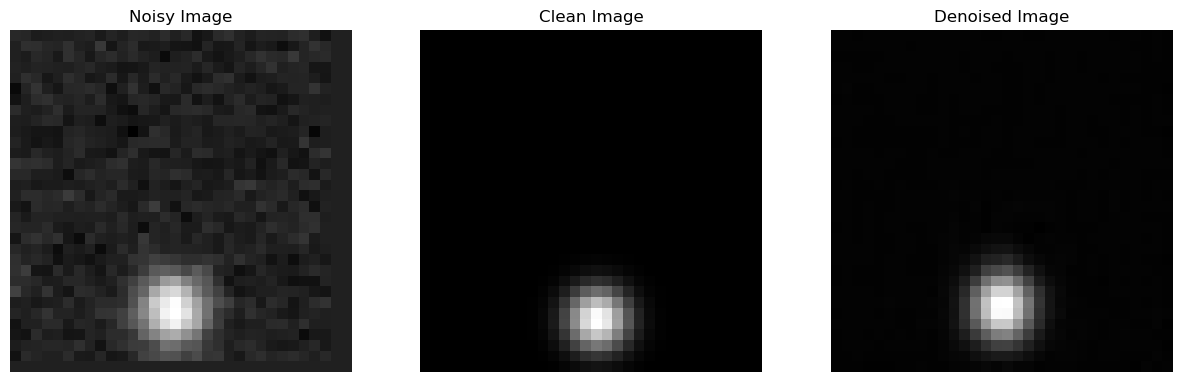

[[ 1.26012019e-04+6.50521303e-18j  3.76952288e-04-2.19592712e-05j
   7.94656225e-04-9.28983573e-05j ... -8.13912671e-09-1.23653692e-08j
  -4.04990574e-09-5.43582468e-09j -2.68455147e-09-3.19688986e-09j]
 [ 3.76952288e-04+2.19592712e-05j  1.13144156e-03+5.70092584e-13j
   2.39332300e-03-1.39416676e-04j ... -2.21925500e-08-3.84081105e-08j
  -1.11676215e-08-1.69664727e-08j -7.47346540e-09-1.00309938e-08j]
 [ 7.94656225e-04+9.28983573e-05j  2.39332300e-03+1.39416676e-04j
   5.07974252e-03+1.40540773e-11j ... -4.22109387e-08-8.39787333e-08j
  -2.15321041e-08-3.72650248e-08j -1.45724970e-08-2.21393091e-08j]
 ...
 [-8.13912671e-09+1.23653701e-08j -2.21925500e-08+3.84081105e-08j
  -4.22109387e-08+8.39787333e-08j ...  1.73910203e-12-1.97314112e-20j
   7.94993032e-13-4.63107912e-14j  4.87101407e-13-5.69436059e-14j]
 [-4.04990574e-09+5.43582468e-09j -1.11676215e-08+1.69664727e-08j
  -2.15321041e-08+3.72650284e-08j ...  7.94993032e-13+4.63108149e-14j
   3.64647169e-13-1.98362435e-21j  2.24184278e-

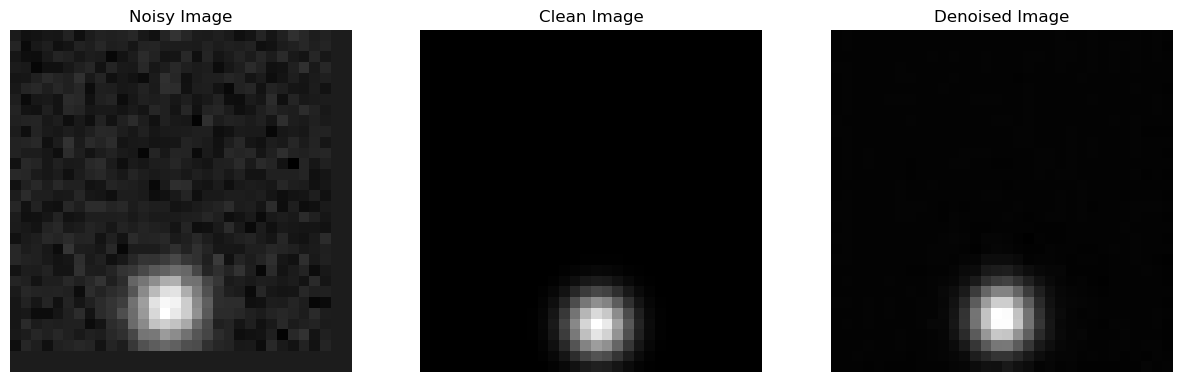

[[ 3.67760449e-03+0.0000000e+00j  8.69301986e-03-4.9430906e-04j
   1.44829070e-02-1.6524154e-03j ... -3.55634133e-11-6.0578313e-11j
  -1.46425823e-11-2.1980367e-11j -6.97369593e-12-9.2797428e-12j]
 [ 8.69301986e-03+4.9430906e-04j  2.06147581e-02+5.0635496e-11j
   3.44563983e-02-1.9592773e-03j ... -7.59214427e-11-1.4797343e-10j
  -3.16573365e-11-5.3924702e-11j -1.52369332e-11-2.2872537e-11j]
 [ 1.44829070e-02+1.6524154e-03j  3.44563983e-02+1.9592773e-03j
   5.77781238e-02-2.2731450e-10j ... -1.12834624e-10-2.5454494e-10j
  -4.77883011e-11-9.3140863e-11j -2.32938044e-11-3.9678302e-11j]
 ...
 [-3.55634133e-11+6.0578306e-11j -7.59214427e-11+1.4797343e-10j
  -1.12834624e-10+2.5454494e-10j ...  1.34176688e-18+2.3507494e-26j
   5.03663089e-19-2.8639827e-20j  2.20295465e-19-2.5134666e-20j]
 [-1.46425823e-11+2.1980367e-11j -3.16573365e-11+5.3924702e-11j
  -4.77883011e-11+9.3140863e-11j ...  5.03663089e-19+2.8639839e-20j
   1.89672863e-19-8.8332700e-28j  8.32294657e-20-4.7327010e-21j]
 [-6.97369

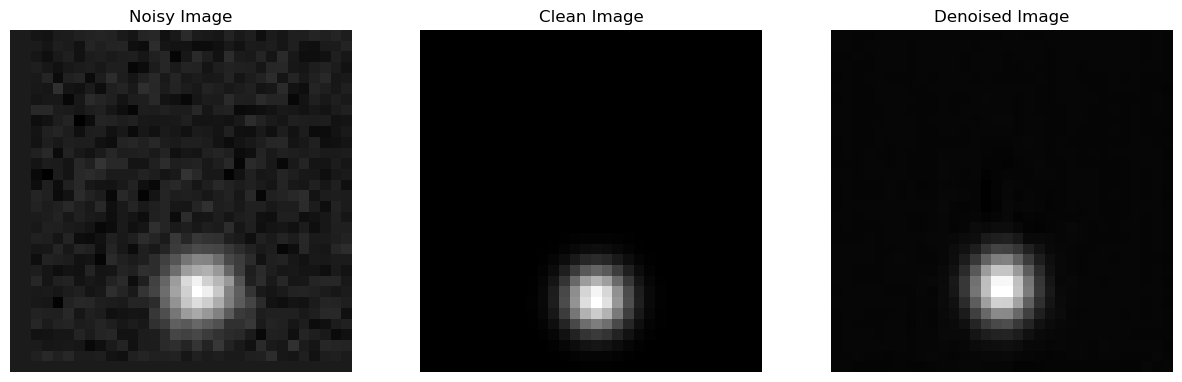

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
<class 'numpy.ndarray'>
Optimal value: 0.13150277899839255
Fidelity: 0.47499347230019684
True diag:         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [0.12313 0.47499 0.17935 0.05399 0.00871 0.00624 0.0047  0.00599 0.0061
 0.00387 0.00481 0.0076  0.0089  0.00371 0.00378 0.00843 0.00431 0.00317
 0.00424 0.00818 0.00606 0.00381 0.0033  0.00502 0.00403 0.00551 0.00381
 0.00176 0.00479 0.00381 0.0013  0.00514 0.00254 0.0029  0.00253 0.00447
 0.00196 0.00562 0.00181 0.00563]
Optimal value: 0.006310589190169155
Fidelity: 0.9970316091555993
True diag:         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

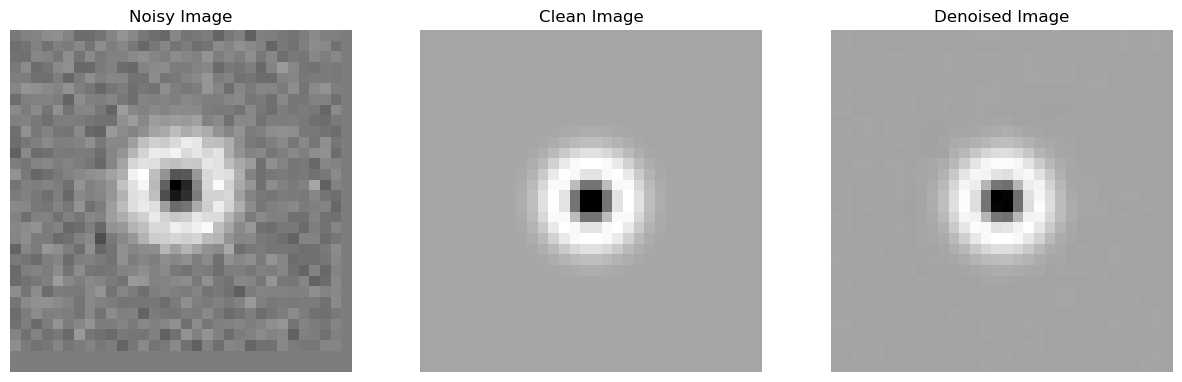

In [40]:
# Initialize the model
model = ConvResMLPDAE_32x32()

# Load the trained model's state dictionary
model.load_state_dict(torch.load('conv_res_mlp_dae_32x32.pth'))
model.eval()

test_dataset = WignerNPZDataset("wigner_test4_32/", normalize=True)
sample_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

for i in range(10):
    noisy, clean, dm = next(iter(sample_loader))
    noisy = noisy.to('cpu')
    clean = clean.to('cpu')

    with torch.no_grad():
        denoised = model(noisy)

    x = np.linspace(-4, 4, 32)
    y = np.linspace(-4, 4, 32)
    # Convert to numpy for visualization
    clean_np = clean.squeeze().numpy()
    noisy_np = noisy.squeeze().numpy()
    
    dm = np.array(dm)
    dm = dm.squeeze(0)

    print(type(dm))
    
    data_noisy = (x, y, noisy_np)
    fidelity_noisy = fit_dm(data_noisy, dm, N=1, dim_ext=60, dim=40)
    
    denoised_np = denoised.squeeze().numpy()
    data_denoised = (x, y, denoised_np)
    fidelity_denoised = fit_dm(data_denoised, dm, N=1, dim_ext=60, dim=40)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(noisy_np, cmap='gray')
    axes[0].set_title('Noisy Image')
    axes[0].axis('off')

    axes[1].imshow(clean_np, cmap='gray')
    axes[1].set_title('Clean Image')
    axes[1].axis('off')

    axes[2].imshow(denoised_np, cmap='gray')
    axes[2].set_title('Denoised Image')
    axes[2].axis('off')

    plt.show()